# Промежуточный отчёт о проделанной работе

In [1]:
import datetime

from script.core.transformers import *
from script.core.models import *
from script.core.dataset import Watcher
from script.core.utils import read_dataset, get_result, logging
from script.core.pipeline import Pipeline

# linear models
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# sklearn feachure extractors
from sklearn.feature_extraction.text import CountVectorizer as count
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf

# CNN
from script.models.cnn import CNN

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mks/envs/intent_script/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
2018-03-25 11:03:55.323 DEBUG in 'matplotlib.backends'['__init__'] at line 90: backend module://ipykernel.pylab.backend_inline version unknown


### На данный момент общий вид нашего функционала выглядит следующим образом. У нас есть набор отдельных сущностей на которых всё строится: датасет, трансформер, векторайзейр, модель, и пайплайн. Из комбинации различных трансформеров, моделей и векторайзеров строится пайплайн. Внутри пайплайна, между операциями ходит специальный класс датасет, который содержит в себе все данные, необходимые для операций. 

### Для каждой сущности написаны базовые классы со стандартизированными интерфесами (как в sklearn). Наследуюясь от которых, можно легко написать что-нибудь новое. Всё что нужно написать (в данном примере для трансформера), это метод _transform в котором содержится логика преобразования данных, и инициализацию. Например так вот выглядит создание рабочего опечаточника: 

In [2]:
class Speller(BaseTransformer):
    def __init__(self, config=None):
        if config is None:
            self.config = {'op_type': 'transformer',
                           'name': 'Speller',
                           'request_names': ['base'],
                           'new_names': ['base'],
                           'path': './DeepPavlov/deeppavlov/configs/error_model/brillmoore_kartaslov_ru.json'}
        else:
            need_names = ['path']
            for name in need_names:
                if name not in config.keys():
                    raise ValueError('Input config must contain {}.'.format(name))

            self.config = config

        super().__init__(self.config)

        self.conf_path = self.config['path']
        with open(self.conf_path) as config_file:
            self.config_ = json.load(config_file)
        
        for name in self.config_.keys():
            self.config[name] = self.config_[name]

        self.speller = build_model_from_config(self.config_)
        

    def _transform(self, dataset):
        print('[ Speller start working ... ]')

        request, report = dataset.main_names
        for name, new_name in zip(self.request_names, self.new_names):
            data = dataset.data[name]
            refactor = list()

            for x in tqdm(data[request]):
                refactor.append(self.speller([x])[0])

            dataset.data[new_name] = pd.DataFrame({request: refactor,
                                                   report: data[report]})

        print('[ Speller done. ]')
        return dataset

### Все операций (трансформеры, векторайзеры, модели) имеют свой конфиг, дефолтная версия которых забита в операции по умолчанию, или может приниматься в качестве входного параметра. Так же как в библиотеке sklearn реализованы методы  .get_params(), возвращающий конфиг словарь,  и .set_params() позволяющий задать новый набор параметров, в том числе и уже проинициализированной операции.

In [3]:
spell_conf = Speller().get_params()
print(spell_conf)

2018-03-25 11:04:02.428 INFO in 'deeppavlov.vocabs.typos'['typos'] at line 76: Loading a dictionary from /home/mks/projects/intent_classification_script/DeepPavlov/download/russian_words_vocab
2018-03-25 11:04:07.769 INFO in 'deeppavlov.models.spellers.error_model.error_model'['error_model'] at line 239: loading error_model from `/home/mks/projects/intent_classification_script/DeepPavlov/download/error_model/error_model_ru.tsv`


{'op_type': 'transformer', 'name': 'Speller', 'request_names': ['base'], 'new_names': ['base'], 'path': './DeepPavlov/deeppavlov/configs/error_model/brillmoore_kartaslov_ru.json', 'dataset_reader': {'name': 'typos_kartaslov_reader'}, 'dataset': {'name': 'typos_dataset', 'test_ratio': 0.02}, 'chainer': {'in': ['x'], 'in_y': ['y'], 'pipe': [{'name': 'str_lower', 'id': 'lower', 'in': ['x'], 'out': ['x_lower']}, {'name': 'nltk_tokenizer', 'id': 'tokenizer', 'in': ['x_lower'], 'out': ['x_tokens']}, {'ref': 'tokenizer', 'in': ['y'], 'out': ['y_tokens']}, {'fit_on': ['x_tokens', 'y_tokens'], 'in': ['x_tokens'], 'out': ['y_predicted'], 'name': 'spelling_error_model', 'window': 1, 'dictionary': {'name': 'russian_words_vocab'}, 'save_path': 'error_model/error_model_ru.tsv', 'load_path': 'error_model/error_model_ru.tsv'}], 'out': ['y_predicted']}, 'train': {'validate_best': False, 'test_best': True}}


In [4]:
spell_conf['name'] = 'New speller'
spell = Speller().set_params(spell_conf)

2018-03-25 11:04:08.382 INFO in 'deeppavlov.vocabs.typos'['typos'] at line 76: Loading a dictionary from /home/mks/projects/intent_classification_script/DeepPavlov/download/russian_words_vocab
2018-03-25 11:04:13.676 INFO in 'deeppavlov.models.spellers.error_model.error_model'['error_model'] at line 239: loading error_model from `/home/mks/projects/intent_classification_script/DeepPavlov/download/error_model/error_model_ru.tsv`
2018-03-25 11:04:14.254 INFO in 'deeppavlov.vocabs.typos'['typos'] at line 76: Loading a dictionary from /home/mks/projects/intent_classification_script/DeepPavlov/download/russian_words_vocab
2018-03-25 11:04:18.841 INFO in 'deeppavlov.models.spellers.error_model.error_model'['error_model'] at line 239: loading error_model from `/home/mks/projects/intent_classification_script/DeepPavlov/download/error_model/error_model_ru.tsv`


# Read csv file and create Dataset

### Ниже приведена простенькая функция для создания объекта класса Dataset (для удобства в демонстрации). Базовый класс Dataset инициализируется от объекта класса DataFrame (или словаря с ключами [train, valid, test]/[train, test]) , и обладает широким функционалом. Может разбивать данные с нужными пропорциями (как с сохранением исходного распределения данных по классам, так и без), объединять несколько разделов один, генерировать батчи нужной размерности, или почередно возвращать все элементы списка, удалять указанные разделы. При гулянии по пайплану в датасет может как добавляться новые данные, так и удаляться старые. 

### Существует две версии датасета: базовая (Dataset) и Watcher (объявленный ниже). Watcher обладает расширенным функционалом позволяющим осуществлять логирование данных при прохождении через пайплайн, на каждом шага, он обновляет общий конфиг всего пайплайна, и проверяет встречал ли он такой конфиг ранее, если нет, то данные сохраняются в виде csv файла, в специальном месте с уникальным именем. 

In [5]:
def init_dataset():
    path = './data/russian/data/vkusvill_all_categories.csv'
    global_data = read_dataset(path)
    date = datetime.datetime.now()
    dataset = Watcher(global_data, date, seed=42)
    dataset = dataset.split([0.1, 0.1])

    print(dataset.data.keys())
    print(len(dataset.data['valid']))

    data = dataset.data['test']
    dataset = Watcher(data, date, seed=42)
    print(dataset.data.keys())
    
    return dataset

# Operations

### Для естиматоров и трансформеров из библиотеки sklearn, написаны обёртки sktransformer и skmodel соответственно, весь функционал sklearn поддерживается.  Ниже пример инициализации с заранее написанным конфигом, в него так же можно записывать все дополнительные параметры которые относятся непосредственно к объекту sklearn-a.

In [6]:
tfidf_conf_1 = {'op_type': 'vectorizer', 'name': 'tf-idf vectorizer',
                'request_names': ['train', 'valid', 'test'], 'new_names': ['train_vec', 'valid_vec', 'test_vec']}
tfidf_ = sktransformer(tfidf, tfidf_conf_1)

In [14]:
# spl_conf = {'op_type': 'transformer',
#             'name': 'Speller',
#             'request_names': ['base'],
#             'new_names': ['base'],
#             'path': './DeepPavlov/deeppavlov/configs/error_model/brillmoore_kartaslov_ru.json'}

# tok_conf = {'op_type': 'transformer',
#             'name': 'Tokenizer',
#             'request_names': ['base'],
#             'new_names': ['base']}

# lem_conf = {'op_type': 'transformer',
#             'name': 'Lemmatizer',
#             'request_names': ['base'],
#             'new_names': ['base']}

concat = TextConcat()


tfidf_conf_2 = {'op_type': 'vectorizer', 'name': 'tf-idf_vectorizer',
                'request_names': ['train', 'valid', 'test'], 'new_names': ['train_vec', 'valid_vec', 'test_vec']}

# Neural Models

### Я постарался написать базовый класс для нейронных моделей наиболее рационально, дабы было меньше проблем с обёртыванием. В основном изменения в исходном модели будут связаны с тем как модель будет получать данные из датасета (батчеварение, и вот это вот всё), учитывая что датасет поддерживает генерацию батчей, и прочие плюшки, переписать это будет скорее всего не слишком сложно. (Я плохой конечно пример, так как изначально знал что мне надо искать в датасете и т.д, но модель Диляры мне удалось нормально обернуть с нуля (то что лежит в deepmipt/intent_recognition) минут за 20-25 (10 написание кода, и 15 минут отладка))

### Если модели для инициализации требуются какие-то дополнительные данные, то просто поверх базовой модели пишеться свой инит, где мы в конфиг модели записываем то что хотим, а берем всё из датасета. Например для построения дилиной модели требуется знать какое количество классов в нашем датасете, можно сконфигурировать пайплайн таким образом, чтобы вся необходимая нам информация была в датасете к во времени его прихода в модель. (это может быть очень удобно в некоторых случаях, особенно учитывая что операции в пайплайне инициилизируются только когда до них доходит очередь)

In [8]:
class GetCNN(BaseModel):
    def init_model(self, dataset):
        classes = dataset.get_classes()
        classes = ' '.join([str(x) for x in classes])
        self.config['classes'] = classes
        
        super().init_model(dataset)
        
        return self

# просто функция для удобства и компактности, до тех пор пока нет генератора конфигов 
def get_cnn_conf(path, emb_path, fit_names=None, predict_names=None, new_names=None):
    with open(path, 'r') as conf:
        config = json.load(conf)

    config['op_type'] = 'model'
    config['name'] = 'cnn'
    
    if fit_names is not None:
        config['fit_names'] = fit_names
    else:
        config['fit_names'] = ['train_vec']
    
    if predict_names is not None:
        config['predict_names'] = predict_names
    else:
        config['predict_names'] = ['test_vec']
        
    if new_names is not None:
        config['new_names'] = new_names
    else:
        config['new_names'] = ['predicted_test']
    
    config['fasttext_model'] = emb_path
    
    return config

path_0 = './configs/models/CNN/CNN_opt.json'
path_1 = './configs/models/CNN/cnn.json'
emb_path = './data/russian/embeddings/ft_0.8.3_nltk_yalen_sg_300.bin'

# Neural Model
config = get_cnn_conf(path_1, emb_path)
WCNN = GetCNN(CNN, config)

### Модель имеет методы: fit() - return None; predict() - return Dataset object with predictions and others info; fit_predict() - return Dataset object; predict_data() - return a list of model predictions; fit_predict_data(); save(); restore(); get_params(); set_params(); e.t.c. Наличие такого набора методов позволяет оперировать моделями, трансформерами и векторайзерами(забыл кстати сказать с програмной точки зрения они такие же как трансформеры, так что разделение условное) не только в рамках пайплайна, но и виде простого кода на питоне.

# Pipeline

## Базовый класс Pipeline принимает на вход список операций как в sklearn, этот список операций задаётся в виде [(op1, op1_config), ....] объекты внутри tuple могут быть как инициализированы, так и нет, а на месте op_config может быть как None, так и вообще ничего не быть (тогда операции инициилизируются с дефолтными конфигами). Также у пайплайна есть два режима работы (mode): train/infer; а также параметр output, который определяет какой объект мы получим на выходе пайплайна. В режиме train, пайплайн может выдать только None, а в режиме infer, может выдать как dataset объект, так и список предсказаний последней модели.

## У пайплайна есть методы: .run() - запускает прогон пайплайна в режиме, который был определён при инициализации; .fit() - только тренирует; .predict(); .get_last_model() - Возвращает последнюю модель в пайплайне (если метод вызвать после обучения, то соответственно выдатст обученную модель); .get_models() - возвращает список всех моделей. И т.д. Вот пример:

In [ ]:
neuro_pipe = [(spell,), (Tokenizer,), (FasttextVectorizer,), (WCNN,), (GetResult,)]
pipeline_1 = Pipeline(neuro_pipe, mode='infer', output='dataset')

## В примере выше последняя операция GetResult осуществляет проверку предсказаний на тестовой части датасета по всем имеющимся метрикам, и записывает результаты в отдельный лог файл, в котором хранятся все логи прогонов за сутки. (Позже там будут храниться все логи за один запуск скрипта, а имя будет с уникальным хешем как с данными, чуточку не успел дописать).

## Таким образом при прогоне нескольких пайплайнов, у нас создаётся список логов, а когда настаёт пора их проверять, отдельные функции просматривают эти логи, и на их основе строят графики, таблицы, и т.д.

# Далее будет пример прогона пяти разных пайплайнов, на 5 разных моделях, с дальнейшим выводом результатов. 

## В целях экономии времени, ни в одном из пайплайнов нету опечаточника, однако он исправно работает, я честно проверял.

# Pipelines with Neural Models

In [9]:
config = get_cnn_conf(path_1, emb_path)
dataset = init_dataset()
WCNN = GetCNN(CNN, config)
neuro_pipe = [(Tokenizer, ), (FasttextVectorizer,), (WCNN,), (GetResult,)]
pipeline_1 = Pipeline(neuro_pipe, mode='infer', output='dataset')
neurodata = pipeline_1.run(dataset)

/home/mks/envs/intent_script/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (6,7,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
 11%|█         | 491/4475 [00:00<00:00, 4907.49it/s]

dict_keys(['train', 'valid', 'test'])
4475
dict_keys(['base'])
[ Starting tokenization ... ]


  0%|          | 0/3597 [00:00<?, ?it/s]

[ Tokenization was done. ]
[ Starting vectorization ... ]
[ Vectorization of train part of dataset ... ]


 43%|████▎     | 189/439 [00:00<00:00, 1853.42it/s]

[ Vectorization of valid part of dataset ... ]


 38%|███▊      | 167/439 [00:00<00:00, 1669.27it/s]

[ Vectorization of test part of dataset ... ]


100%|██████████| 439/439 [00:00<00:00, 1733.33it/s]


[ Vectorization was ended. ]
[ Initializing intent_model from scratch ]

____Training over 3597 samples____


train -->	updates: 1	loss: 0.33391445875167847	fmeasure: 0.0	 
epochs_done: 1
train -->	updates: 58	loss: 0.2779141962528229	fmeasure: 0.39534878730773926	 
epochs_done: 2


/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Pipelines with Linear Models

In [10]:
conf_0 = {'op_type': 'model', 'name': 'Linear Regression',
          'fit_names': ['train_vec'], 'new_names': ['predicted_test'],
          'predict_names': ['test_vec']}

## Run pipeline with linear regression

In [12]:
# (Tokenizer, tok_conf), (Lemmatizer,), (concat, None),
dataset = init_dataset()
LR = skmodel(LogisticRegression, conf_0)

pipe_0 = [(tfidf_,), (LR,), (GetResultLinear_W,)]
pipeline_0 = Pipeline(pipe_0, mode='train', output=None)
pipeline_1 = Pipeline(pipe_0, mode='infer', output='dataset')
res = pipeline_1.run(dataset)

/home/mks/envs/intent_script/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (6,7,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


dict_keys(['train', 'valid', 'test'])
4475
dict_keys(['base'])


/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Run pipeline with SVC

In [15]:
dataset = init_dataset()

conf_0['name'] = 'LinearSVC'
conf_0['op_type'] = 'model'
LSVC = skmodel(LinearSVC, conf_0)

# (Speller, spl_conf),

pipe_1 = [(Tokenizer, ), (Lemmatizer,), (concat, None), (tfidf_, tfidf_conf_2),
          (LSVC,), (GetResultLinear_W,)]
pipeline_2 = Pipeline(pipe_1, mode='train', output=None)
pipeline_3 = Pipeline(pipe_1, mode='infer', output='dataset')

res = pipeline_3.run(dataset)

/home/mks/envs/intent_script/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (6,7,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
 12%|█▏        | 555/4475 [00:00<00:00, 5545.87it/s]

dict_keys(['train', 'valid', 'test'])
4475
dict_keys(['base'])
[ Starting tokenization ... ]


100%|██████████| 4475/4475 [00:00<00:00, 5247.98it/s]
2018-03-25 11:15:57.496 INFO in 'pymorphy2.opencorpora_dict.wrapper'['wrapper'] at line 16: Loading dictionaries from /home/mks/envs/intent_script/lib/python3.6/site-packages/pymorphy2_dicts/data
2018-03-25 11:15:57.532 INFO in 'pymorphy2.opencorpora_dict.wrapper'['wrapper'] at line 20: format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168
  0%|          | 19/4475 [00:00<00:23, 188.28it/s]

[ Tokenization was done. ]
[ Starting lemmatization ... ]


100%|██████████| 4475/4475 [00:00<00:00, 467915.90it/s]
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[ Ended lemmatization. ]
[ Starting text merging ... ]
[ Text concatenation was ended. ]


/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


##  Run pipeline with Random Forest

In [16]:
dataset = init_dataset()

conf_0['name'] = 'RandomForestClassifier'
conf_0['op_type'] = 'model'
RFC = skmodel(RandomForestClassifier, conf_0)


# (Speller, spl_conf), 
pipe_2 = [(Tokenizer, ), (Lemmatizer,), (concat, None), (tfidf_, tfidf_conf_2),
          (RFC,), (GetResultLinear_W,)]
pipeline_4 = Pipeline(pipe_2, mode='train', output=None)
pipeline_5 = Pipeline(pipe_2, mode='infer', output='dataset')

res = pipeline_5.run(dataset)

/home/mks/envs/intent_script/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (6,7,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
 11%|█▏        | 509/4475 [00:00<00:00, 5084.08it/s]

dict_keys(['train', 'valid', 'test'])
4475
dict_keys(['base'])
[ Starting tokenization ... ]


100%|██████████| 4475/4475 [00:00<00:00, 5354.16it/s]
2018-03-25 11:16:34.311 INFO in 'pymorphy2.opencorpora_dict.wrapper'['wrapper'] at line 16: Loading dictionaries from /home/mks/envs/intent_script/lib/python3.6/site-packages/pymorphy2_dicts/data
2018-03-25 11:16:34.343 INFO in 'pymorphy2.opencorpora_dict.wrapper'['wrapper'] at line 20: format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168
  0%|          | 21/4475 [00:00<00:22, 201.12it/s]

[ Tokenization was done. ]
[ Starting lemmatization ... ]


100%|██████████| 4475/4475 [00:00<00:00, 465837.15it/s]
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[ Ended lemmatization. ]
[ Starting text merging ... ]
[ Text concatenation was ended. ]


/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Run pipeline with GBM

In [17]:
dataset = init_dataset()

conf_0['name'] = 'LGBMClassifier'
conf_0['op_type'] = 'model'
LGBM = skmodel(LGBMClassifier, conf_0)

# (Speller, spl_conf),
pipe_3 = [(Tokenizer, ), (Lemmatizer,), (concat, None), (tfidf_, tfidf_conf_2),
          (LGBM,), (GetResultLinear_W,)]
pipeline_6 = Pipeline(pipe_3, mode='train', output=None)
pipeline_7 = Pipeline(pipe_3, mode='infer', output='dataset')

res = pipeline_7.run(dataset)

/home/mks/envs/intent_script/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (6,7,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
 12%|█▏        | 550/4475 [00:00<00:00, 5494.57it/s]

dict_keys(['train', 'valid', 'test'])
4475
dict_keys(['base'])
[ Starting tokenization ... ]


100%|██████████| 4475/4475 [00:00<00:00, 5527.70it/s]
2018-03-25 11:17:05.216 INFO in 'pymorphy2.opencorpora_dict.wrapper'['wrapper'] at line 16: Loading dictionaries from /home/mks/envs/intent_script/lib/python3.6/site-packages/pymorphy2_dicts/data
2018-03-25 11:17:05.241 INFO in 'pymorphy2.opencorpora_dict.wrapper'['wrapper'] at line 20: format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168
  0%|          | 21/4475 [00:00<00:21, 204.14it/s]

[ Tokenization was done. ]
[ Starting lemmatization ... ]


100%|██████████| 4475/4475 [00:00<00:00, 436815.16it/s]


[ Ended lemmatization. ]
[ Starting text merging ... ]
[ Text concatenation was ended. ]


/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

# Вывод Результатов

In [19]:
from script.core.utils import scrab_data, get_table, plot_i, plot_j, plot_k

path = './results/logs/2018-3-25.txt'
info = scrab_data(path)
table, [name_best_model, best_model] = get_table(info)

print('The best model: {}'.format(name_best_model))
table

The best model: LinearSVC


,Accuracy,F1 macro,F1 weighted
Models,,,
LGBMClassifier,0.643836,0.512065,0.632016
Linear Regression,0.602740,0.372529,0.559509
LinearSVC,0.684932,0.532844,0.668673
RandomForestClassifier,0.599089,0.410288,0.575240
cnn,0.136760,0.058972,0.125233


## У cnn модели такой маленький скор из-за бага оценки, при обучении на валиде она показывала нормальные результаты для 2-х эпох. Не успел оперативно отловить. Исправлю.

2018-03-25 11:24:18.624 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1354: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/mks/intent/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-03-25 11:24:18.685 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1354: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/mks/intent/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


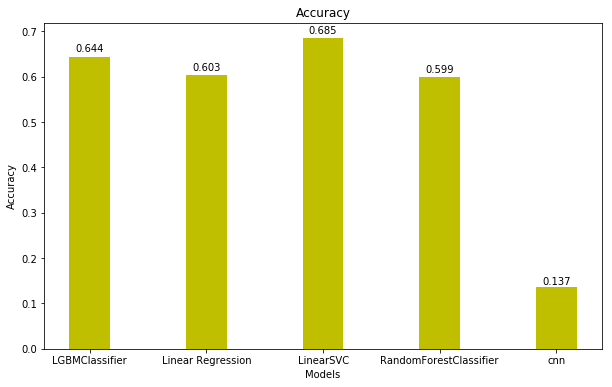

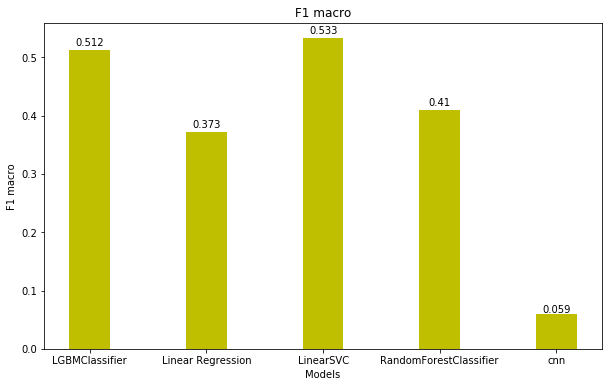

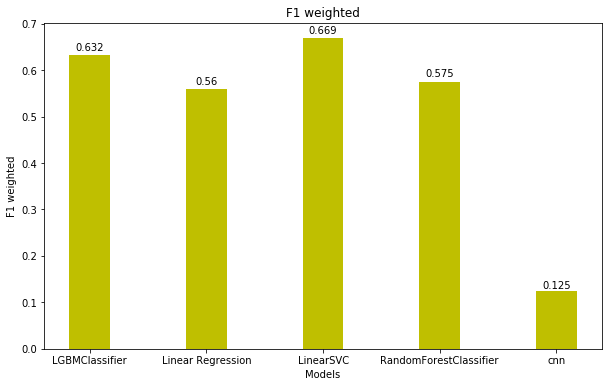

In [20]:
plot_i('2018-3-25')

# Значение F1-wighted меры, для каждого отдельного класса (лучшая модель)

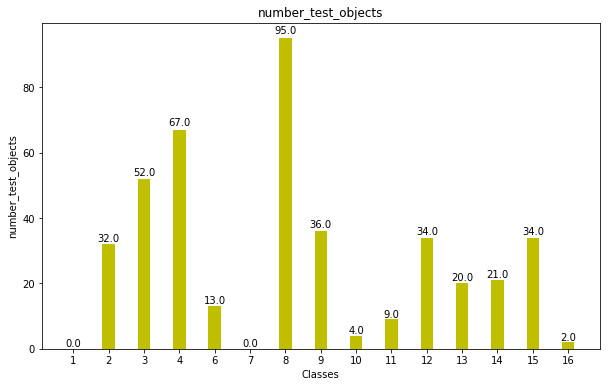

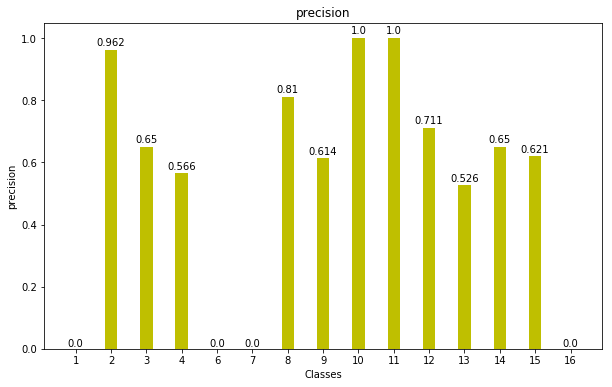

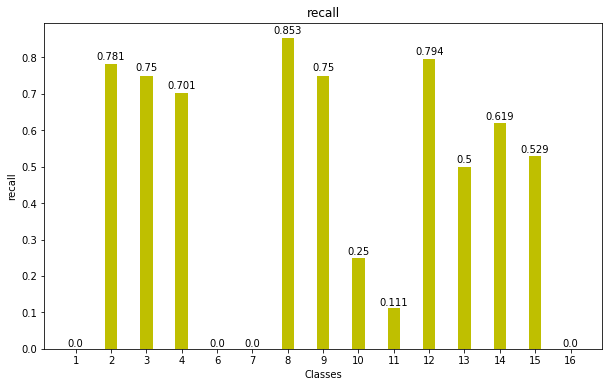

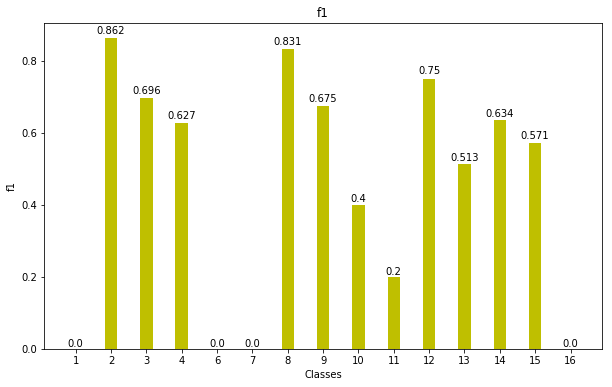

In [21]:
plot_k('2018-3-25')

## Все изорбражения и таблица, автоматически сохраняются в отдельную папку.

# Плюсы:

### - По моему сугубо личному мнению, вполне удобно для использования.

### - Довольно просто прикрутить подбор гиперпараметров у моделей

### - Архитектура очень гибка и позволяет делать то что обычный пайплайн из Sklearn-a сделать не смог. Например разбить текст на токены, каждому токену сопоставить его эмбеддинг, а потом взвесить эти эмбеддинги tf-idf коэфициентами, чтобы получить эмбеддинг одного предложения. Выполнить такое преобразование невозможно в рамках пайплайна sklearn-a, а здесь можно очень просто реализовать либо как две последовательные операции, либо как одну.

### - Архитектура пайплайна позволяет, получать при его прохождении какие-нибудь данные, необходимые для модели, и спокойно довозить до нужной позиции пайплайна.

### - Оборачивать модели в местные классы вроде как тоже не очень сложно

### - Вроде как есть неплохой потенциал для дальнейшего развития

# Минусы:

### - На данный момент в пайплайне нету серьёзной защиты стыков между операциями по типу данных. (Исправим)

### - Самый большой минус на данный момент, по моему мнению в том, что между операциями движется весь датасет целиком, это понятное дело затратно по памяти, особенно когда векторизуем текст для нейронок. Хотелось бы что мы могли гонять по пайплайну отдельные батчи, с нужного нам момента.

### - Базовые модели можно ещё дополировывать

# Дальнейшие планы:

### 1) Написать генератор конфигов пайплайнов и генератор конфигов для отдельных моделей. (За понедельник думаю управлюсь)

### 2) Написать класс PipelineManager(), который будет управлять всем действом связанным с прогонами пайплайнов и общего скоринга. Он должен будет генерировать разные пайплайны, с разными параметрами, поочерёдно их запускать, управлять подгрузкой данных, для уже совершённой предобработки, и т.д. (Вт-Чт (Пт думаю максимум))

### 3) Написать отдельный обёртчик для моделей на Keras. У таких моделей хороший и структурированный интерфес, поэтому для него не сложно будет написать крутой класс обёртчик, которому можно будет скормить только скомпилированный граф, или функцию которая это делает. Тогда для таких моделе писанины сильно сократиться. (Например в случае модели Дили код с 512 строчек сократился бы до 40) (Выходные)

### 4) Устроить полный тест на Snips и Вкусвилле

### 5) Хотелось бы такой волшебный обёртчик и для моделей на tf написать. но это задача уже куда сложне, но можно подумать.

### 6) Хочется добавить блендинг моделей

### 7) Расширять функционал